## **Aplicação de Random Forest Regression**
Neste notebook será aplicado o modelo Random Forest Regression utilizando as features extraídas dos dados .
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA**, **ETS** e **Regressão Linear**. 

In [1]:
# confirgurando diretório
import os
os.chdir("..")

# importando bibliotecas
import warnings
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from main.features import add_features
from main.evaluation import Evaluation
from main.plots import plot_metrics
from main.plots import plot_time_series

# configurando notebook
tqdm.pandas()

warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%load_ext autoreload
%autoreload 2

EVAL_PATH = 'notebooks/data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("notebooks/data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("notebooks/data/test_df.csv", parse_dates=['ds'])

In [3]:
features_train_df = (
    train_df
    .groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='train'))
    .reset_index(drop=True)
)

features_test_df = (
    test_df
    .groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='test'))
    .reset_index(drop=True)
)

## **Random Forest Regression**

In [14]:
def random_forest(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo RandomForest.
    """    
    train = df.copy().reset_index(drop=True)
    test = features_test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train['trend'] = train.index
    test['trend'] = test.index + train.index.max() + 1
    
    m = RandomForestRegressor(
        n_estimators=1000, 
        max_depth=10, 
        min_samples_split=4, 
        random_state=1001
    )
    
    m.fit(
        X=train.iloc[:,3:], 
        y=train.y
    )
    
    test['y_pred'] = m.predict(X=test.iloc[:,3:])

    return test

In [15]:
# aplicando modelo para cada série
rf_fcst = features_train_df.groupby("unique_id").apply(random_forest).reset_index(drop=True)

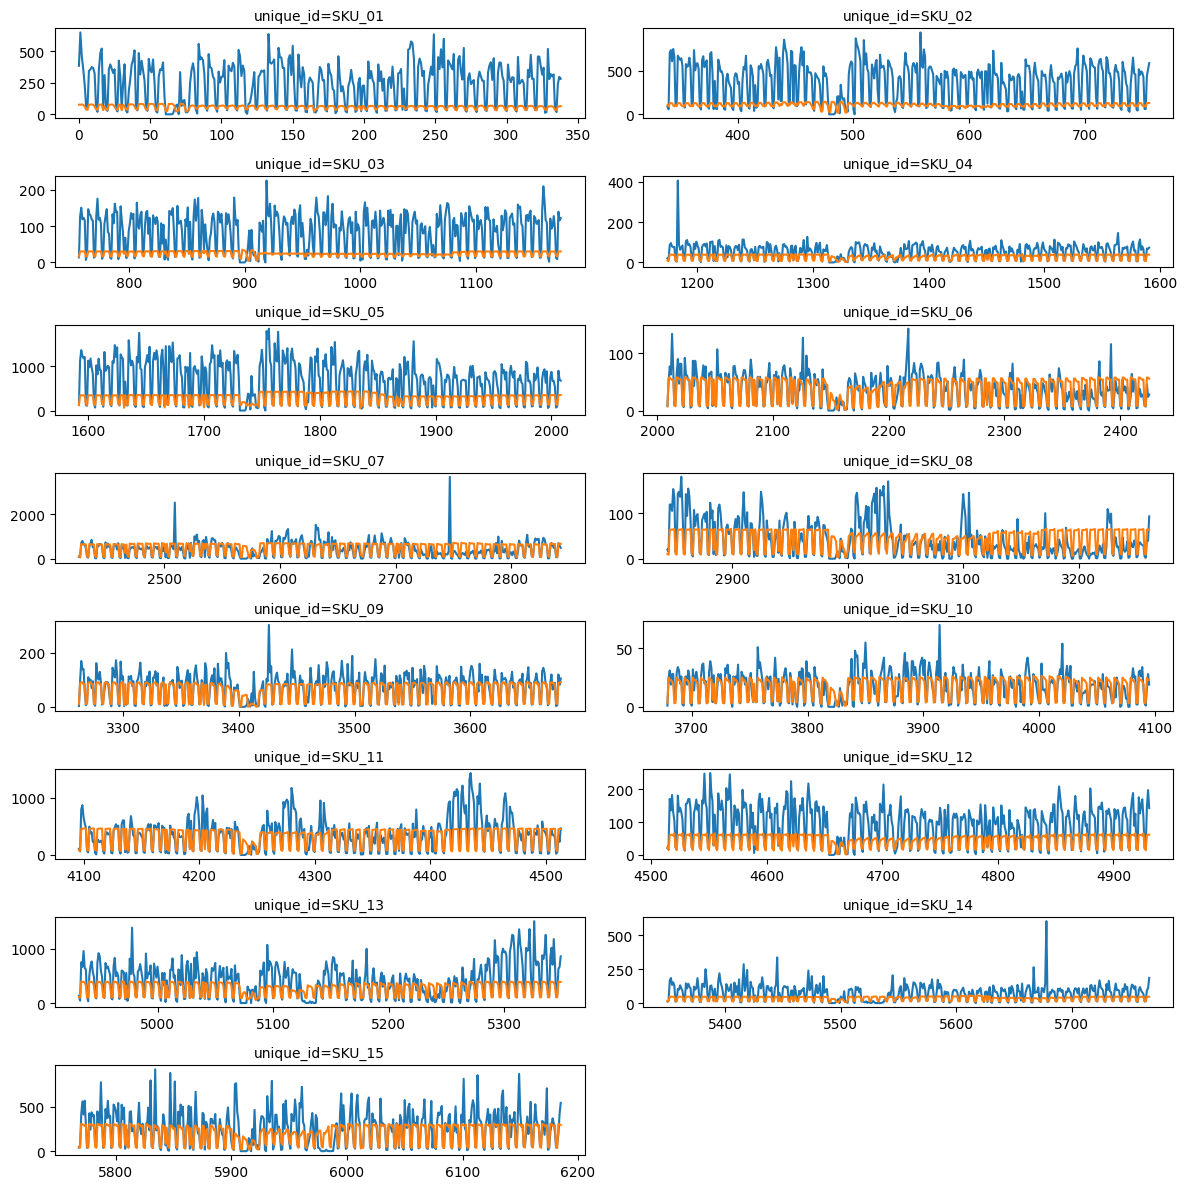

In [16]:
plot_time_series(
    df = rf_fcst,
    data_cols=['y','y_pred'],
    grid=(8, 2),
    figsize=(12, 12)
)

In [17]:
rf_eval = Evaluation(rf_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'Random Forest v2')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,194.02,59362.66,243.64,-1.10
SKU_02,282.11,118403.95,344.10,-1.26
SKU_03,63.33,6037.25,77.70,-1.15
SKU_04,27.20,1486.13,38.55,-0.02
SKU_05,431.63,300265.19,547.96,-0.41
SKU_06,12.09,295.43,17.19,0.58
SKU_07,191.05,88927.39,298.21,0.38
SKU_08,24.05,1105.80,33.25,0.34
SKU_09,20.38,1012.99,31.83,0.62
SKU_10,5.57,61.64,7.85,0.61


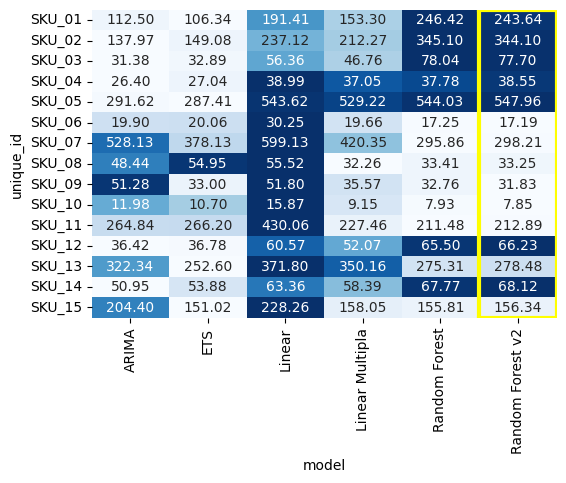

In [18]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)[['unique_id', 'rmse', 'model']].pivot_table('rmse','unique_id','model')
plot_metrics(metrics, hl_col='Random Forest v2', figsize=(6, 4))